In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,f1_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")
from tqdm import tqdm
import pmdarima as pm
from statsmodels.tsa.ar_model import AutoReg,AR
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import pacf
import json
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
import pymc3 as pm

TypeError: Plain typing.NoReturn is not valid as type argument

In [2]:
def check_adf(column):# return p value
    adf_result=adfuller(column)
    if adf_result[1]<=0.05:
        return 'Stationary'
    else:
        return 'Non-Stationary'
    

def get_diff_order(data):
    if check_adf(data)=='Non-Stationary':
        if check_adf(data.diff().dropna())=='Non-Stationary':
            diff_order=2
        else:
            diff_order=1
    else:
        diff_order=0
    return diff_order

def find_Feature_lag(df,target,maxlag,diff_order,p):
    df_sample=df.copy()
    best_aic = np.inf
    best_lag = None
    max_lag=maxlag
    for i in range(1,max_lag+1):
        df_sample[target]=df_sample[target].shift(i)
        df_c=df_sample.dropna()
        model=SARIMAX(df_c[['unweighted_ili']],df_c[target],order=(p,diff_order,0))
        results=model.fit()
        if results.aic<best_aic and results.aic>0:
            best_aic=results.aic 
            best_lag=i
        if best_aic<0 or not best_lag:
            best_lag=2
    return best_lag

def _create_lags(data,maxlag,diff_order,p):
    datax=data.copy()
    for i in datax.columns:
        if i!='unweighted_ili':
            best_lag_value=find_Feature_lag(data,i,maxlag,diff_order,p)
            datax[i + "_lag" + str(best_lag_value)]=datax[i].shift(best_lag_value)
            datax=datax.drop(i,axis='columns')
    return datax
def best_ili_lag(df,maxlag,diff_order):
    best_aic = np.inf
    best_lag = None
    max_lag=maxlag
    for i in range(1,max_lag+1):
        model=ARIMA(df[['unweighted_ili']],order=(i,1,0))
        results=model.fit()
        if results.aic<best_aic and results.aic>0:
            best_aic=results.aic 
            best_lag=i
        if best_aic<0 or not best_lag:
            best_lag=2
        return best_lag

In [3]:
df=pd.read_csv('df_final.csv')
df['date']=pd.to_datetime(df['date'])
df1=df.set_index('date',drop=True)
states=df1['state'].unique()
states_dict={}

In [4]:
df

,date,state,elderly_mode,school_mode,masking_mode,school_contin,elderly_contin,mask_oxford_contin,unweighted_ili,flu_av7,...,mask_av7,rr_av7,gp_av7,park_av7,transit_av7,work_av7,resid_av7,school_av7,elderly_av7,mask_policy_av7
0,2019-09-29,AL,NaN,NaN,NaN,NaN,NaN,NaN,1.97633,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-09-29,AK,NaN,NaN,NaN,NaN,NaN,NaN,1.04516,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-09-29,AZ,NaN,NaN,NaN,NaN,NaN,NaN,1.06620,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-09-29,AR,NaN,NaN,NaN,NaN,NaN,NaN,1.19323,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-09-29,CA,NaN,NaN,NaN,NaN,NaN,NaN,1.36062,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,2022-12-25,VA,1.0,0.0,1.0,0.000000,33.333333,25.0,5.29949,37.28571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
8496,2022-12-25,WA,2.0,1.0,2.0,33.333333,66.666667,50.0,4.75230,52.85714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8497,2022-12-25,WV,2.0,0.0,1.0,0.000000,66.666667,25.0,2.83938,33.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8498,2022-12-25,WI,2.0,0.0,1.0,0.000000,66.666667,25.0,2.83194,59.28571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
for i in tqdm(states):
    df1_st=df1[df1['state']==i]['2020-03-22':'2022-06-26']
    df2_st=df1_st[['elderly_mode','school_mode','unweighted_ili','mask_av7','rr_av7','gp_av7','transit_av7',
                  'work_av7','resid_av7']]
    df2_st[['elderly_mode','school_mode']]=df2_st[['elderly_mode','school_mode']].astype('object')
    df2_st_=pd.get_dummies(df2_st,drop_first=True)
    diff_order=get_diff_order(df2_st_['unweighted_ili'])
    p=best_ili_lag(df2_st_,4,diff_order)
    data_new=_create_lags(df2_st_,4,diff_order,p)
    df_c1=data_new.dropna()
    model=SARIMAX(df_c1[['unweighted_ili']],df_c1[df_c1.columns[1:]],order=(p,diff_order,0))
    results=model.fit()
    state_df = pd.DataFrame({'coef': round(results.params,3), 'p_value': round(results.pvalues,3)})
    state_df.loc[state_df['p_value'] <= 0.05, 'significant'] = 'Yes'
    state_df.loc[state_df['p_value'] > 0.05, 'significant'] = 'No'
    states_dict[i]=state_df

100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


In [22]:
i='CA'
df1_st=df1[df1['state']==i]['2020-03-22':'2022-06-26']
df2_st=df1_st[['elderly_contin','school_contin','unweighted_ili','mask_oxford_contin','rr_av7','gp_av7','transit_av7',
              'work_av7','resid_av7']]
#df2_st[['elderly_mode','school_mode']]=df2_st[['elderly_mode','school_mode']].astype('object')
#df2_st_=pd.get_dummies(df2_st,drop_first=True)
diff_order=get_diff_order(df2_st['unweighted_ili'])
p=best_ili_lag(df2_st,4,diff_order)
data_new=_create_lags(df2_st,4,diff_order,p)
df_c1=data_new.dropna()
model=SARIMAX(df_c1[['unweighted_ili']],df_c1[df_c1.columns[1:]],order=(p,diff_order,0))
results=model.fit()
state_df = pd.DataFrame({'coef': round(results.params,3), 'p_value': round(results.pvalues,3)})
state_df.loc[state_df['p_value'] <= 0.05, 'significant'] = 'Yes'
state_df.loc[state_df['p_value'] > 0.05, 'significant'] = 'No'

In [23]:
state_df

,coef,p_value,significant
elderly_contin_lag2,0.019,0.060,No
school_contin_lag3,-0.010,0.097,No
mask_oxford_contin_lag2,-0.003,0.783,No
rr_av7_lag3,0.027,0.058,No
gp_av7_lag3,0.005,0.705,No
transit_av7_lag3,-0.035,0.074,No
work_av7_lag2,-0.011,0.418,No
resid_av7_lag2,-0.029,0.548,No
ar.L1,1.146,0.000,Yes
ar.L2,-0.406,0.000,Yes


In [36]:
#df_cluster.to_csv('df_cluster.csv', index=True)


In [3]:

"""data_dict = {k: v.to_dict() for k, v in states_dict.items()}

# serialize the dictionary using json
json_data = json.dumps(data_dict)

# write the JSON string to a file
with open('data.json', 'w') as f:
    f.write(json_data)"""
with open('data.json') as f:
    json_data = f.read()

# convert the JSON string to a dictionary
data_dict = json.loads(json_data)

# convert the dictionary to DataFrames
data_From_load = {k: pd.DataFrame.from_dict(v) for k, v in data_dict.items()}

In [4]:
data_From_load['TX']

,coef,p_value,significant
elderly_mode_lag2,-0.199,0.315,No
school_mode_lag2,-0.284,0.000,Yes
mask_av7_lag2,0.005,0.701,No
rr_av7_lag2,0.018,0.314,No
gp_av7_lag2,-0.007,0.623,No
transit_av7_lag2,0.015,0.000,Yes
work_av7_lag2,-0.023,0.010,Yes
resid_av7_lag2,-0.038,0.471,No
ar.L1,0.266,0.000,Yes
ar.L2,-0.086,0.304,No


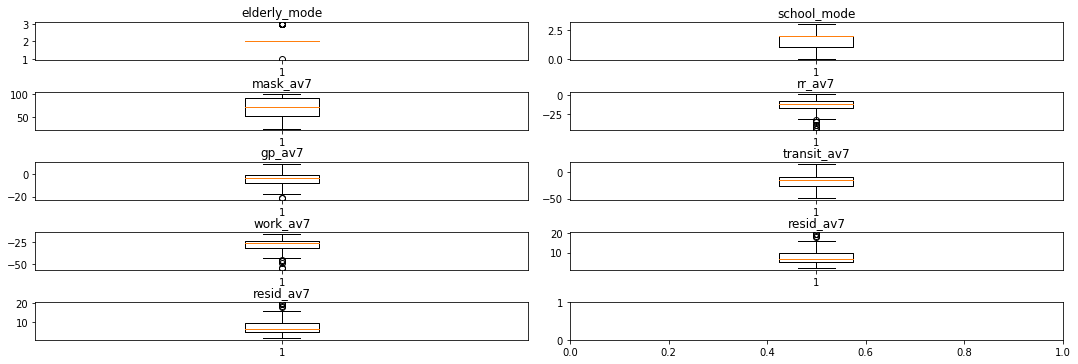

In [116]:
"""def visualize_all_columns(df,ili):
    nrow=5
    ncol=2
    i=0
    fig, axes = plt.subplots(nrow, ncol,figsize=(15,15))
    fig.tight_layout()
    for r in range(nrow):
        for c in range(ncol):
            c1=ili
            c2=df[df.columns[i]]
            corr=round(c1.corr(c2),2)
            axes[r,c].plot(c1,label='il')
            axes[r,c].legend(['{:.2f}'.format(corr)],
                    loc = 'upper left',fontsize=20)
            ax2=axes[r,c].twinx()
            ax2.plot(c2,color='red',label=df.columns[i])
            ax2.legend()
            if i==len(df.columns)-1:
                break
            i+=1

def visualize_all_columns_outliers(df):
    nrow=5
    ncol=2
    i=0
    fig, axes = plt.subplots(nrow, ncol,figsize=(15,5))
    fig.tight_layout()
    for r in range(nrow):
        for c in range(ncol):
            axes[r,c].boxplot(df[df.columns[i]])
            axes[r,c].set_title(df.columns[i])
            if i==len(df.columns)-1:
                break
            i+=1
visualize_all_columns_outliers(df2_tx)"""